# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch
from collections import deque
from ddpg_multi_agents import Multi_Agents, GaussianNoise, OUNoise
import os
import json
import os.path
import matplotlib.pyplot as plt

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="./Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
agents_count = states.shape[0]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


## 3. Solving the environment : find best distribution of hyper parameters

The Tennis environment is solved using a DDPG (Deep Determinic Policy Gradient). Common reinforcement learning techniques as DQN could not be applied here since it only apply to discrete action spaces in the sense that it searches for the action that maximize the action value function at each iteration.

The DDPG algorithm introduces many parameters we can play on to speed up the convergence and the final score of the trained agent :

- **buffer_size** : The size of the replay buffer in the context of the *Experience replay*,
- **batch_size** : The size of the batch involved in the update enhanced using *Experience replay*,
- **gamma_start** : The discount factor involved in the rewards expectation at the begining of the training,
- **gamma_end** : The maximum discount factor,
- **gamma_decay** : The discount factor increase coefficient at each iteration,
- **(fc1, fc2)** : the size of the first and the second layer of the fully connected neural networks that are used for the actor and for the critic.
- **lr_actor** : the learning rate of the neural netowrk of the actor,
- **lr_critic** : the learning rate of the neural netowrk of the critic,
- **noise** : the noise applied on the actor output to ease exploration, we test different parameterizations of the Ornstein-Uhlenbeck process suggested in the course but also test different gaussian noises.
- **noise_factor_end** : the minimum coefficient applied to the noise factor (starting at 1 at the beginning of the training)
- **noise_factor_decay** : the decay coefficient applied to the noise factor 

### 3.1 Define hyper parameter values to test

The following cell introduces all the values we test for the hyper parameters described above :


In [5]:
#env.close()

In [6]:
# The values to test for each parameter
hyper_parameters = {
        'inbalanced_replay_memory_positive_reward_ratio' : [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9],
        'lr_actor, lr_critic' : [(1e-4, 1e-4), (1e-4, 1e-3), (1e-3, 1e-4), (1e-3, 1e-3)],
        '(fc1,fc2)' : [(128, 128), (128, 256), (256, 128), (256, 512), (512, 256)],
        'buffer_size':[int(1e5), int(1e6), int(1e7)],
        'batch_size':[512, 1024, 2048, 4096],
        '(gamma_start, gamma_end, gamma_increase)':[
            (0.9, 0.99, 1.001),
            (0.95, 0.995, 1.001),
            (0.99, 0.999, 1.001),
            (0.995, 0.9995, 1.001)
        ],
        '(tau_start, tau_end, tau_decay)':[
            (0.005, 0.0005, 0.999),
            (0.01, 0.001, 0.999),
            (0.05, 0.005, 0.999)
        ],
        'noise' : [
                   GaussianNoise(action_size, 0.1),
                   GaussianNoise(action_size, 0.5),
                   GaussianNoise(action_size, 1.0),
                   OUNoise(action_size, 0, 0., 0.075, 0.1),
                   OUNoise(action_size, 0, 0., 0.15, 0.2),
                   OUNoise(action_size, 0, 0., 0.3, 0.4)
                  ],
        'noise_factor_decay':[0.9, 0.99, 0.999],
        '(update_rate, update_count)' :[(1, 1), (10, 5), (5, 10), (10, 10), (10, 20), (20, 10), (20, 20)]
    }

default_parameters = {
        'lr_actor, lr_critic' : (1e-4, 1e-4),
        '(fc1,fc2)' :  (256, 256),
        'buffer_size':int(1e5),
        'batch_size':1024,
        '(gamma_start, gamma_end, gamma_increase)' : (0.95, 0.995, 1.001),
        '(tau_start, tau_end, tau_decay)' : (0.01, 0.001, 0.999),
        #'noise' : OUNoise(action_size, 0, 0., 0.15, 0.2)
         'noise' : GaussianNoise(action_size, 0.5),
         'noise_factor_end' : 0.01,
         'noise_factor_decay' : 0.99,
         '(update_rate, update_count)' : (20, 20),
         'inbalanced_replay_memory_positive_reward_ratio' : 0
    }
 
def to_name(parameters) :
    """
    built a user friendly string that describes a particular experiment,
    specified by a value distribution for parameters
    """
    return ' '.join('{}={}'.format(name, str(value)) for name, value in parameters.items())


def parameters_to_agent(parameters) :
    buffer_size = parameters['buffer_size']
    batch_size = parameters['batch_size']
    fc1_units, fc2_units = parameters['(fc1,fc2)']
    lr_actor, lr_critic = parameters['lr_actor, lr_critic']
    noise = parameters['noise']
    lr_actor, lr_critic = parameters['lr_actor, lr_critic']
    update_rate, update_count = parameters['(update_rate, update_count)']
    inbalanced_replay_memory_positive_reward_ratio = parameters['inbalanced_replay_memory_positive_reward_ratio']
    return Multi_Agents(
        agents_count,
        state_size,
        action_size,
        0,
        buffer_size,
        batch_size,
        fc1_units,
        fc2_units,
        noise,
        lr_actor,
        lr_critic,
        update_rate,
        update_count, 
        inbalanced_replay_memory_positive_reward_ratio
    )
    

### 3.2 A stop and resume implementation for hyper-parameterization : Save partial result
Our hyper parameters tuning heuristic implies to training many times the agent. Since this is time consuming, we save the result after each training to be able to stop and resume our computations when we want without loosing what has already been computed. 

In [7]:
# load what has already been computed
if os.path.exists('hyper_parameters_tuning.json'):
    with open('hyper_parameters_tuning.json') as json_file:
        results = json.load(json_file)
else :
    results = {}


### 3.3 training routine
The following **ddpg** routine run the specified number of episodes per agent with the specified number of timeframe per episode. It is very similar to the implementation provided in the Udacity course (for instance [ddpg-pendulum](https://github.com/udacity/deep-reinforcement-learning/tree/master/ddpg-pendulum)) except that data like *actions*, *states*, *next_states*, *rewards*, *dones* are no longer single values but arrays (one value per agent).

Since we implemented an hyper parameters tuning, we now receive the hyper parameters of the algorithm in the routine. 

In [8]:
def ddpg(parameters,name,n_episodes=2000, max_t=10000000, train_mode = True, agent = None):
    if agent is None :
        agent = parameters_to_agent(parameters)
        
    gamma, gamma_end, gamma_increase = parameters['(gamma_start, gamma_end, gamma_increase)']
    tau, tau_end, tau_decay = parameters['(tau_start, tau_end, tau_decay)']
    noise_factor = 1.0
    noise_factor_decay = parameters['noise_factor_decay']
    noise_factor_end = parameters['noise_factor_end']
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=train_mode)[brain_name] 
        states = env_info.vector_observations
        score = np.zeros(agents_count)
        for t in range(max_t):
            actions = agent.act(states, True, noise_factor)
            env_info = env.step(actions)[brain_name] 
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            agent.step(states, actions, rewards, next_states, dones, gamma, tau)
            states = next_states
            score += rewards
            if np.any(dones):
                break 
        #print(f'score = {score}')
        scores.append(np.max(score))
        scores_deque.append(np.max(score))
        print(f'Episode {i_episode}\t\
        score = {np.max(score)},\
        mean prev 100 = {np.mean(scores_deque)},\
        gamma = {gamma},\
        tau={tau}, noise_factor={noise_factor}\
        #positive_rewards = {len(agent.memory.positive_reward_memory) if agent.memory.inbalanced else "-"},\
        #negative rewards = {len(agent.memory.negative_reward_memory) if agent.memory.inbalanced else "-"},\
        ', end='\r')
        
        
        if train_mode :
            torch.save(agent.actor_local.state_dict(), f'checkpoint_actor({name}).pth')
            torch.save(agent.critic_local.state_dict(), f'checkpoint_critic({name}).pth')
        agent.reset()  
        
        gamma = min(gamma_end, gamma*gamma_increase)
        tau = max(tau_end, tau*tau_decay)
        noise_factor = max(noise_factor_end, noise_factor*noise_factor_decay)
    return agent, scores


## 3.4 Evaluate each value for each hyper parameter
Train the agent for 200 iterations and save a json that gives for each experiment the value at each iteration

In [9]:
# find sequentially the "best" value for each parameters after 200 episodes. 
# When a parameter is choosen, the others take values from the dqn project

for name, parameter in hyper_parameters.items() :
    
    for value in parameter :
        key = '{}_{}'.format(name, str(value))
        if not key in results :
            print("\n\nTuning parameter {}, value = {}".format(name, value))
            parameters = default_parameters.copy()
            parameters[name] = value
            print(parameters)
            _, scores = ddpg(parameters, name, 2000)
            results[key] = scores
            with open('hyper_parameters_tuning.json', 'w') as fp:
                json.dump(results, fp)       
        else :
            print("\nparameter {}, value = {} already tuned".format(name, value))
with open('hyper_parameters_tuning.json', 'w') as fp:
    json.dump(results, fp) 


parameter inbalanced_replay_memory_positive_reward_ratio, value = 0.01 already tuned

parameter inbalanced_replay_memory_positive_reward_ratio, value = 0.05 already tuned

parameter inbalanced_replay_memory_positive_reward_ratio, value = 0.1 already tuned

parameter inbalanced_replay_memory_positive_reward_ratio, value = 0.25 already tuned

parameter inbalanced_replay_memory_positive_reward_ratio, value = 0.5 already tuned

parameter inbalanced_replay_memory_positive_reward_ratio, value = 0.75 already tuned

parameter inbalanced_replay_memory_positive_reward_ratio, value = 0.9 already tuned

parameter lr_actor, lr_critic, value = (0.0001, 0.0001) already tuned

parameter lr_actor, lr_critic, value = (0.0001, 0.001) already tuned

parameter lr_actor, lr_critic, value = (0.001, 0.0001) already tuned

parameter lr_actor, lr_critic, value = (0.001, 0.001) already tuned

parameter (fc1,fc2), value = (128, 128) already tuned

parameter (fc1,fc2), value = (128, 256) already tuned

parameter 

## 4. Solving the environment : Train the model with the best hyper parameters values find before

In [10]:
chosen_parameters = {
        'lr_actor, lr_critic' : (1e-4, 1e-4),
        '(fc1,fc2)' :  (256, 512),
        'buffer_size':int(1e6),
        'batch_size':1024,
        '(gamma_start, gamma_end, gamma_increase)' : (0.95, 0.995, 1.001),
        '(tau_start, tau_end, tau_decay)' : (0.005, 0.0005, 0.999),
         'noise' : OUNoise(action_size, 0, 0., 0.3, 0.4),
         'noise_factor_end' : 0.01,
         'noise_factor_decay' : 0.99,
         '(update_rate, update_count)' : (10, 20),
         'inbalanced_replay_memory_positive_reward_ratio' : 0.01
    }
agent, scores = ddpg(chosen_parameters, 'best')

len(positive_reward_memory) = 10000, len(negative_reward_memory) = 990000


## Plot the scores to show that it is above 0.5 for more than 100 iterations

In [12]:
final_scores = {}
final_scores['best'] = scores
with open('final_scores.json', 'w') as fp:
    json.dump(final_scores, fp)  

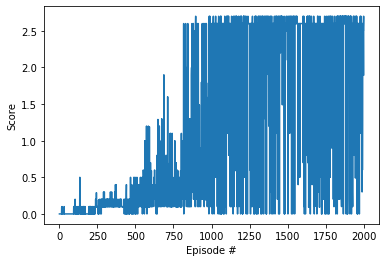

None

In [13]:


scores = list(scores)
# plot the score
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
display(plt.show())